Feature Regressions using Machine Learning (ML) & Deep Learning (DL) Algorithms

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-05-16 12:51:17.747267: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 12:51:17.838071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 12:51:29.365096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
import shap 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
trajl = 41
wellsInfo = 'Awells'
conditions = ['A2'] # LIGANDS or CONDITIONS
tmSet = ['EGF1']
n_conditions = len(tmSet) # Total number of Ligand Conditions
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [7]:
# Indices for the ligands 
inds_tmSet = [i for i in range(n_conditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 2
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/']
imagingSet = [0 for i in range(n_conditions)]
modelList = [None]*(nfovs*(n_conditions))
modelList_conditions = np.zeros(nfovs*(n_conditions)).astype(int)

In [8]:
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
       modelList_conditions[i] = icond
       modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fov)+dateSet[imagingSet[icond]]
       #print("Models: ",modelList[i])
       i += 1
    icond += 1

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [9]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells


In [10]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [11]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [12]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)

inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    for fov in range(nfovs):
        inds_tmSet_models[i] = inds_tmSet[icond] # Assign indices "tmSet" to all FOVs
        inds_imagingSet_models[i] = imagingSet[icond]
        i += 1
    icond = icond + 1

In [13]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0 #just replace with zeros for now? Not sure best...

In [14]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [15]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        # Indices for each model for later access using them
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [16]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xf = Xf[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [17]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell

In [18]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory 
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

Single-cell Trajectories Over The Cell Features

In [19]:
Xf_traj = np.zeros((0, n_features*trajl + n_COMfeatures*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf[modelSet[i].traj, :] 
    datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf.shape[1]*trajl)
    datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Building trajectory data for model: 0
Building trajectory data for model: 1


In [20]:
inds_conditions = [None]*n_conditions
for imf in range(n_conditions):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for im in indmodels:
        indtm = np.where(indtreatment_traj == im)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy() # Condition (Model) specific trajectory snippet indices: Add up all FOVs
    #print(inds_conditions[imf])

In [21]:
# Get Cross correlations & respective frame numbers along all single-cell trajectories
def get_cross_corr_all_single_cell_trajs(filename):
      cross_corr_sctraj = []
      frame_num_sctraj = []
      with open(filename, 'r') as file_in:
          # Create an iterator over the file lines 
          file_iter = iter(file_in)
          try:
              while True:
                  # Read two lines at a time: Cross correlations & the corresponding frame numbers
                  line1 = next(file_iter).strip()
                  if line1:
                          data = ast.literal_eval(line1)
                          cross_corr_sctraj.append(data)
                          line2 = next(file_iter).strip()
                          # Parse line2 as a list of integers
                          frame_numbers = ast.literal_eval(line2)   
                          frame_num_sctraj.append(frame_numbers)
          except StopIteration:
              # End of file reached
              pass
      cross_corr_all_sctraj_file = cross_corr_sctraj
      frame_num_all_sctraj_file = frame_num_sctraj
      
      return cross_corr_all_sctraj_file, frame_num_all_sctraj_file

In [22]:
cc_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/dcompCCtraj_states/'

In [23]:
# Get cross-correlation values along all single-cell trajectories (sorted as per trajectory length) 
cc_filename = f"{cc_path}{sysName}_{conditions[0]}_1.dat"
cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

In [24]:
cc_values_last_frames = []
model_indc = 0
indstm = np.where(indtreatment_traj == model_indc)[0]
fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
################## Identify the "FULL" trajectory index and locate snippets within it ##################
for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
    possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])  
    indc_ccvals_traj = possible_indices[0][0]
    #print(f'Indices of Entire Traj: {ind_fulltraj}, Indices of CC_traj: {indc_ccvals_traj}')
    cc_vals = cross_correlations[ind_fulltraj][indc_ccvals_traj]
    #print(f'CC values: {cc_vals}, Indices of Entire Traj: {ind_fulltraj}, Indices of CC trajectory: {indc_ccvals_traj}')
    cc_values_last_frames.append(cc_vals)
cc_values_last_frames = np.array(cc_values_last_frames)
X_traj_model = Xf_traj[indstm]
X_test = X_traj_model
y_test = cc_values_last_frames

In [25]:
# Get cross-correlation values along all single-cell trajectories (sorted as per trajectory length) 
cc_filename = f"{cc_path}{sysName}_{conditions[0]}_2.dat"
cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

In [26]:
cc_values_last_frames = []
model_indc = 1
indstm = np.where(indtreatment_traj == model_indc)[0]
fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
################## Identify the "FULL" trajectory index and locate snippets within it ##################
for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
    possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])  
    indc_ccvals_traj = possible_indices[0][0]
    #print(f'Indices of Entire Traj: {ind_fulltraj}, Indices of CC_traj: {indc_ccvals_traj}')
    cc_vals = cross_correlations[ind_fulltraj][indc_ccvals_traj]
    #print(f'CC values: {cc_vals}, Indices of Entire Traj: {ind_fulltraj}, Indices of CC trajectory: {indc_ccvals_traj}')
    cc_values_last_frames.append(cc_vals)
cc_values_last_frames = np.array(cc_values_last_frames)
X_traj_model = Xf_traj[indstm]
X_train = X_traj_model
y_train = cc_values_last_frames

In [136]:
n_features = 325 # 325 corresponds to 0.99 variance of he test set
pca = PCA(n_components = n_features)
#pca = PCA(n_components = 0.99)

In [137]:
pca.fit(X_train) 
Xpca_train = pca.transform(X_train)
print(f"Number of Features afer PCA: {Xpca_train.shape[1]}")

Number of Features afer PCA: 325


In [138]:
pca.fit(X_test) 
Xpca_test = pca.transform(X_test)
print(f"Number of Features afer PCA: {Xpca_test.shape[1]}")

Number of Features afer PCA: 325


In [139]:
data = y_test
variance = np.var(data)
std_dev = np.std(data)
print(f"Variance of the data: {variance}")
print(f"Standard deviation of the data: {std_dev}")

Variance of the data: 0.059469900056613276
Standard deviation of the data: 0.24386451167936116


Know The Outliers!

In [140]:
threshold = 2. * std_dev 
mean_data = np.mean(data)
# Identify outliers: Data beyond "mean +/- 2*standard_deviation"
outliers = data[(data < mean_data - threshold) | (data > mean_data + threshold)] 
non_outliers = data[(data >= mean_data - threshold) & (data <= mean_data + threshold)]
print(f"Outliers: {outliers}, Length of Outliars: {len(outliers)}")
print(f"Non-outliers: {non_outliers}, Length of non-outliars: {len(non_outliers)}")

Outliers: [ 0.12670848 -0.0454792  -0.01339921  0.06472085  0.12121155  0.07727984
  0.12593909  0.12947478  0.0949446   0.05908539  0.0998493  -0.02996746
  0.05895596  0.08532889  0.06343031  0.10824234 -0.02550145  0.06582297
  0.05851169  0.1109757   0.07699038  0.06061378  0.06228534  0.08833059
  0.10266882  0.10440305  0.10521702  0.09820999  0.1031753   0.11614981
  0.09464913  0.11458545  0.11462418  0.11638878  0.07876538  0.09108689
  0.09229709  0.1064357   0.03232341  0.06045616  0.08047022  0.07767354
  0.0929372   0.10292375  0.11968237  0.0654952   0.10740515  0.0133443
  0.11726235  0.12506807  0.09164059  0.02526118  0.0349118  -0.06179683
 -0.15184884 -0.29954489  0.03552434 -0.10761754 -0.08122208 -0.14067389
 -0.17617326 -0.14803883  0.07054152  0.12979275  0.05458917  0.04298242
  0.11368284  0.08796326  0.08401645  0.09995611  0.09749425  0.1283384
  0.1021455   0.10943693  0.04943826  0.1004793   0.11827985  0.11903764
  0.08110941  0.02402151 -0.1671993  -0.036

In [141]:
non_outlier_condition = (data >= mean_data - threshold) & (data <= mean_data + threshold)
non_outlier_indices = np.where(non_outlier_condition)[0]

In [142]:
cc_vals_non_outliers_test = y_test[non_outlier_indices]
Xpca_non_outliers_test = Xpca_test[non_outlier_indices]

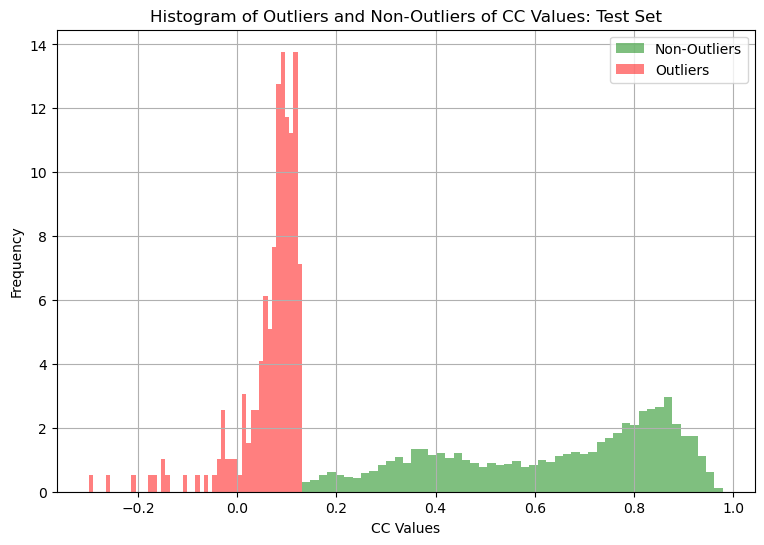

In [143]:
n_bins = 50
plt.figure(figsize=(9, 6))
plt.hist(non_outliers, bins=n_bins, density = True, alpha=0.5, color = 'g', label='Non-Outliers')
plt.hist(outliers, bins=n_bins,  density = True, alpha=0.5, color='r', label='Outliers')

plt.xlabel('CC Values')
plt.ylabel('Frequency')
plt.title('Histogram of Outliers and Non-Outliers of CC Values: Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [144]:
data = y_train
variance = np.var(data)
std_dev = np.std(data)
print(f"Variance of the data: {variance}")
print(f"Standard deviation of the data: {std_dev}")

Variance of the data: 0.06627354676943771
Standard deviation of the data: 0.25743649074953945


In [145]:
threshold = 2. * std_dev 
mean_data = np.mean(data)
# Identify outliers: Data beyond "mean +/- 2*standard_deviation"
outliers = data[(data < mean_data - threshold) | (data > mean_data + threshold)] 
non_outliers = data[(data >= mean_data - threshold) & (data <= mean_data + threshold)]
print(f"Outliers: {outliers}, Length of Outliars: {len(outliers)}")
print(f"Non-outliers: {non_outliers}, Length of non-outliars: {len(non_outliers)}")

Outliers: [ 0.08266008  0.09703115 -0.15356087 ...  0.03001627  0.02503949
  0.02503949], Length of Outliars: 1423
Non-outliers: [0.36103302 0.33505966 0.33689898 ... 0.88287996 0.87425821 0.89634136], Length of non-outliars: 23686


In [146]:
non_outlier_condition = (data >= mean_data - threshold) & (data <= mean_data + threshold)
non_outlier_indices = np.where(non_outlier_condition)[0]

In [147]:
cc_vals_non_outliers_train = y_train[non_outlier_indices]
Xpca_non_outliers_train = Xpca_train[non_outlier_indices]

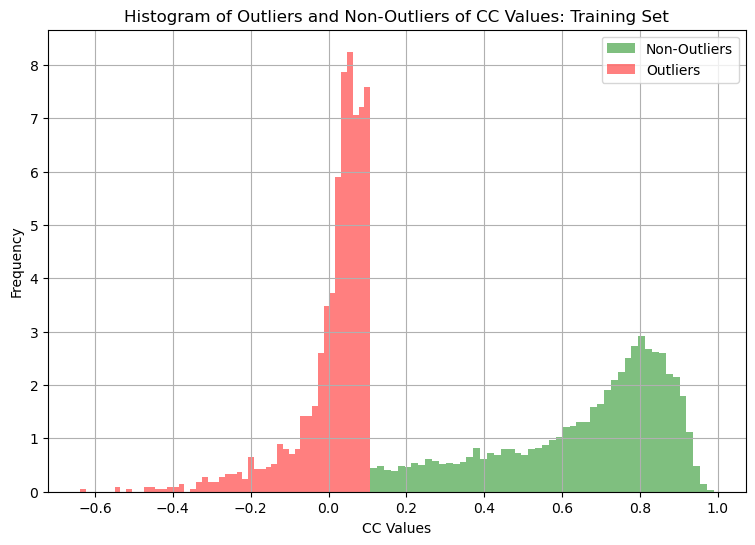

In [148]:
n_bins = 50
plt.figure(figsize=(9, 6))
plt.hist(non_outliers, bins=n_bins, density = True, alpha=0.5, color = 'g', label='Non-Outliers')
plt.hist(outliers, bins=n_bins,  density = True, alpha=0.5, color='r', label='Outliers')

plt.xlabel('CC Values')
plt.ylabel('Frequency')
plt.title('Histogram of Outliers and Non-Outliers of CC Values: Training Set')
plt.legend()
plt.grid(True)
plt.show()

Random Forest Regression Model Using Recursive Feature Elimination with Cross Validations 

In [149]:
n_folds_cv = 10
cv_kFold = KFold(n_splits = n_folds_cv, # n_splits fold cross-validations 
                 shuffle = True,
                 random_state = 42) # Simple K-fold Cross Validations

In [150]:
model_RF = RandomForestRegressor(n_estimators = 40, # Number of Trees 
                                 random_state = 42) 

In [151]:
rfecv_RF = RFECV(estimator = model_RF,
                 step = 1, 
                 cv = cv_kFold, 
                 scoring = 'neg_mean_squared_error',  # Using negative MSE as the scoring method
                 min_features_to_select = 1,
                 verbose = 1,
                 n_jobs = -1)

In [ ]:
rfecv_RF.fit(Xpca_non_outliers_train, cc_vals_non_outliers_train) # Recursive Feature Elimination Cross-Validation

In [42]:
y_pred_RF = rfecv_RF.predict(Xpca_non_outliers_test) # Predicting the test set results

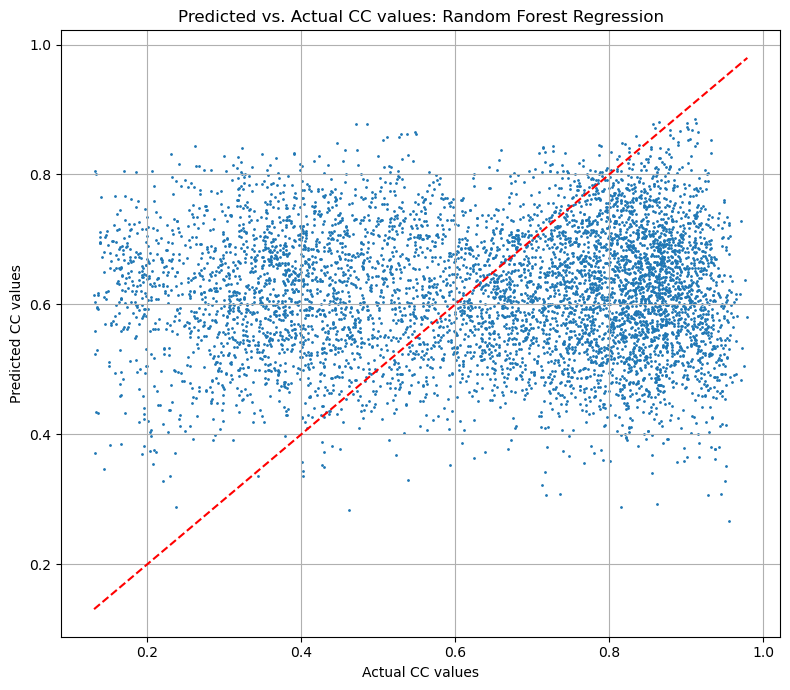

In [43]:
plt.figure(figsize = (8, 7))
plt.scatter(cc_vals_non_outliers_test, y_pred_RF, s = 1)
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Predicted vs. Actual CC values: Random Forest Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(cc_vals_non_outliers_test.min(), y_pred_RF.min())
max_val = max(cc_vals_non_outliers_test.max(), y_pred_RF.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.tight_layout()
plt.savefig(figid+'CCvalsPred_testFOV1_RF.png', dpi=400)
#plt.show()

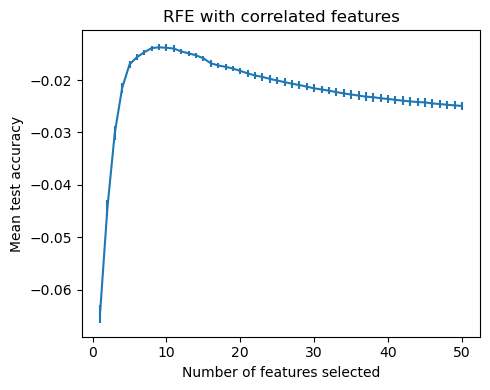

In [44]:
min_features_to_select = 1
n_scores = len(rfecv_RF.cv_results_["mean_test_score"])
plt.figure(figsize = (5, 4))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(range(min_features_to_select, n_scores + min_features_to_select), rfecv_RF.cv_results_["mean_test_score"], 
             yerr=rfecv_RF.cv_results_["std_test_score"])
plt.title("RFE with correlated features")
plt.tight_layout()
plt.savefig(figid+'test_accuracyFOV1_RF.png', dpi=400)
#plt.show()

In [45]:
print(f"Number of Predictive Features: {rfecv_RF.n_features_}")
selected_features = np.where(rfecv_RF.support_ == True)[0] # Identifying the selected features
print(f"Most Predictive Feature Indices:{selected_features}")

Number of Predictive Features: 9
Most Predictive Feature Indices:[ 0  1  2  3  4  5  6  7 25]


In [184]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xpca_non_outliers_train)
X_test_scaled = scaler.transform(Xpca_non_outliers_test)

In [193]:
model_NN = Sequential([Input(shape = (X_train_scaled.shape[1], )),
                       Dense(2048, activation = 'relu'),
                       Dense(1024, activation = 'relu', kernel_regularizer = l2(0.02)),
                       #Dropout(0.2),
                       Dense(512, activation = 'relu'),
                       #LeakyReLU(),
                       Dense(256, activation = 'relu'), 
                       #LeakyReLU(), 
                       #Dropout(0.2),
                       Dense(128, activation = 'relu'),
                       #LeakyReLU(),
                       #Dropout(0.2),
                       Dense(64, activation = 'relu'),
                       #Dropout(0.2),
                       Dense(32, activation = 'relu'),
                       Dense(1)])

In [194]:
optimizer = Adam(learning_rate = 0.0001)
#optimizer = SGD(learning_rate = 0.0001)
model_NN.compile(optimizer = optimizer, loss = 'mean_squared_error')

In [195]:
history = model_NN.fit(X_train_scaled,
                       cc_vals_non_outliers_train,
                       validation_split = 0.2,
                       epochs = 200,
                       batch_size = 16) 

Epoch 1/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.6905 - val_loss: 0.1767
Epoch 2/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0958 - val_loss: 0.0563
Epoch 3/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0386 - val_loss: 0.0541
Epoch 4/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0297 - val_loss: 0.0584
Epoch 5/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0193 - val_loss: 0.0671
Epoch 6/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0116 - val_loss: 0.0675
Epoch 7/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0079 - val_loss: 0.0704
Epoch 8/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0060 - val_loss: 0.0640
Epoch 9/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0048 - val_loss: 0.0611
Epoch 10/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0041 - val_loss: 0.0639
Epoch 11/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0040 - val_loss: 0.0613
Epoch 12/200
1185/1

In [196]:
mse_nn = model_NN.evaluate(X_test_scaled, cc_vals_non_outliers_test)
print(f"Mean Squared Error on Test set: {mse_nn}")

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0674
Mean Squared Error on Test set: 0.06884199380874634


In [197]:
y_pred_nn = model_NN.predict(X_test_scaled)

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


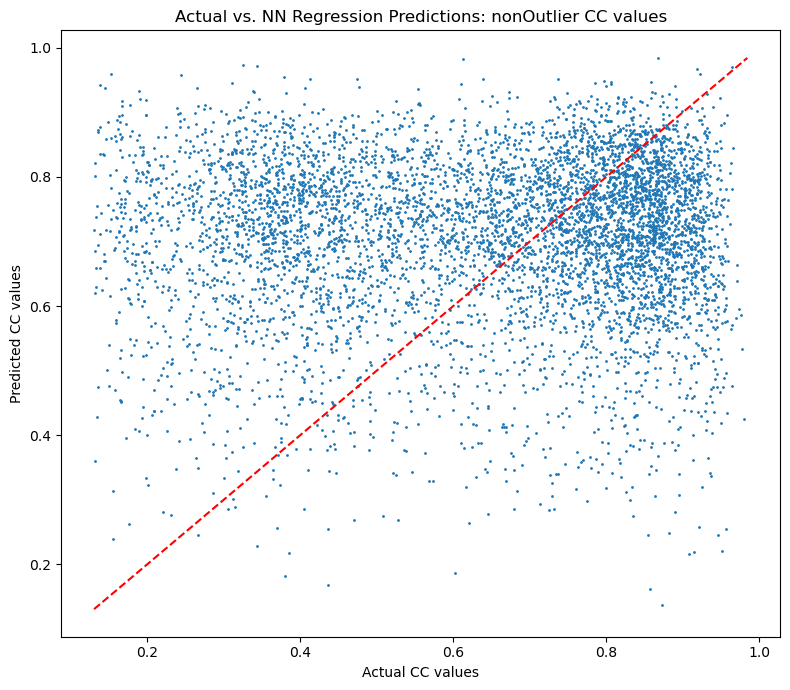

In [198]:
plt.figure(figsize = (8, 7))
plt.scatter(cc_vals_non_outliers_test, y_pred_nn, s = 1)

# Calculate the range to include both actual and predicted values
min_val = min(cc_vals_non_outliers_test.min(), y_pred_nn.min())
max_val = max(cc_vals_non_outliers_test.max(), y_pred_nn.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color = 'red', linestyle = '--')  # Perfect prediction
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Actual vs. NN Regression Predictions: nonOutlier CC values')
plt.tight_layout()
#plt.savefig(figid+'CCvalsPred_testNN.png', dpi=400)
plt.show()

In [ ]:
explainer = shap.KernelExplainer(model_NN.predict, X_train_scaled[:100]) # Create SHAP explainer
shap_values = explainer.shap_values(X_test_scaled) # Compute SHAP values
num_features = X_train_scaled.shape[1]
feature_names = [f'Feature {i}' for i in range(num_features)] # Create generic feature names
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [ ]:
counts, bins = np.histogram(y, n_bins, density=True)
plt.plot(bins[:-1], counts, 'k', label = 'Training + Test')
counts, bins = np.histogram(y_train, n_bins, density=True)
plt.plot(bins[:-1], counts, 'r', label = 'Training Set')
counts, bins = np.histogram(y_test, n_bins, density=True)
plt.plot(bins[:-1], counts, 'b', label = 'Test Set')
plt.xlabel('CC Values')
plt.ylabel('Probability density')
plt.title('EGF_1')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()